In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')

In [3]:
from src_dir import *
import numpy as np

dim=200
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

FD_StencilMat=np.zeros((dim,dim))
b = np.ones(dim-1)
c = -2*np.ones(dim)
np.fill_diagonal(FD_StencilMat[1:], b)
np.fill_diagonal(FD_StencilMat[:,1:], b)
np.fill_diagonal(FD_StencilMat, c)
A=FD_StencilMat
A=np.asmatrix(A)
# A=mk_laplace_1d(dim)
AType='1D Laplacian'

retrain_freq=1
e1 = 1e-4
e2 = 1e-7
nmax_iter =int(dim/5)
restart   = 64

sigma=0.2*5
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =2500
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("1D Linear Test")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-08-11 01:58:55 [INFO] <ipython-input-4-4437744cf7b1> 2 - 1D Linear Test


In [5]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b ,x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list,ML_GMRES_Time_list2,solIndx):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *


ML_GMRES_Time_list=[]
ML_GMRES_Time_list2=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]

solIndx=0

for ProbIdx in range(n_steps):
    
    loc=np.random.uniform(-5,5)
    b=Gauss_pdf(x,loc,sigma)
    b_norm=np.linalg.norm(b)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list,ML_GMRES_Time_list2,solIndx)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm,Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list,ML_GMRES_Time_list2,solIndx)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]
    ML_GMRES_Time_list2=OutList2[6]
    solIndx=OutList2[7]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[5])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    
    MLGMRES_GMRES_ONLY=sum(ML_GMRES_Time_list2)+sum(ML_GMRES_Time_list)

    print(ProbIdx)

run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)

logger.info("Runtime of MLGMRES (only GMRES time) is:")
logger.info(MLGMRES_GMRES_ONLY)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)


0
1
Final loss: 8258.400390625
Initial Training
2
size 8
0.832412071599888 1.076760323704304
0.7299942519966862 0.8960006420020363 0.45996970469015336 0.9304136504899589
0.7299942519966862 0.8960006420020363 0.45996970469015336 0.9304136504899589
3
size 8
0.8784154023840622 1.076760323704304
0.583572046001791 0.864099112997792 0.23123161322103122 0.6220183409828837
0.583572046001791 0.864099112997792 0.23123161322103122 0.6220183409828837
4
size 8
1.0382525661361042 1.076760323704304
0.7584887599950889 0.7705900906657916 1.0274014174067048 0.49175609839559953
0.7584887599950889 0.7705900906657916 1.0274014174067048 0.49175609839559953
5
size 8
1.0851975080457983 1.076760323704304
poor prediction,using initial x0
0.9356247440009611 0.6906850193311888 1.0851975080457998 0.5728675784392965
0.9356247440009611 0.6906850193311888 1.0851975080457998 0.5728675784392965
6
size 8
0.7696172127532911 1.0851975080457998
0.6238390299986349 0.7519199504986318 0.5136622379284935 0.7009500608409223
0.6

41
size 8
0.7776166959088957 1.0851975080457998
0.2655430790036917 0.4938221070397412 0.013651817869484153 0.3060830847875009
0.2655430790036917 0.4938221070397412 0.013651817869484153 0.3060830847875009
42
size 8
0.82779330617116 1.0851975080457998
0.5550663390022237 0.4770646249200217 0.30962621513572736 0.3027283549618842
0.5550663390022237 0.4770646249200217 0.30962621513572736 0.3027283549618842
InnerProd [[1.         0.78324297 0.9547186 ]
 [0.78324297 1.         0.89272482]
 [0.9547186  0.89272482 1.        ]]
retraining
2
Final loss: 1344.34130859375
43
size 8
0.7581374367379489 1.0851975080457998
0.37202549500216264 0.47513623132021165 0.08203029132416904 0.299037523933867
0.37202549500216264 0.47513623132021165 0.08203029132416904 0.299037523933867
44
size 8
1.0651896462054087 1.0851975080457998
0.24965867699938826 0.47018930552032545 0.06725136887675723 0.2872607268434212
0.24965867699938826 0.47018930552032545 0.06725136887675723 0.2872607268434212
45
size 8
1.0204433065870

80
size 8
1.011999745902176 1.0851975080457998
0.33644526999705704 0.32136893287912244 0.27915022056387845 0.1546637776430318
0.33644526999705704 0.32136893287912244 0.27915022056387845 0.1546637776430318
81
size 8
1.0166539403577315 1.0851975080457998
0.25494558900390984 0.318668789199146 0.04417282769919621 0.16249996400654837
0.25494558900390984 0.318668789199146 0.04417282769919621 0.16249996400654837
82
size 8
0.8683464121539197 1.0851975080457998
0.42263566499605076 0.3093702458793996 0.1892433191464837 0.1570336571074057
0.42263566499605076 0.3093702458793996 0.1892433191464837 0.1570336571074057
InnerProd [[1.         0.75085379 0.98815561]
 [0.75085379 1.         0.80515408]
 [0.98815561 0.80515408 1.        ]]
retraining
2
Final loss: 228.15225219726562
83
size 8
0.8540550271228833 1.0851975080457998
0.3767666650019237 0.31330241179908624 0.09333650983889691 0.16149685828703383
0.3767666650019237 0.31330241179908624 0.09333650983889691 0.16149685828703383
84
size 8
1.04494939

0.30874296700494597 0.25034193163970486 0.035308523199266896 0.04014153447116852
0.30874296700494597 0.25034193163970486 0.035308523199266896 0.04014153447116852
119
size 8
0.882173727091993 1.0851975080457998
0.24961852600245038 0.25475450883997836 0.04397500385417762 0.04101210659862632
0.24961852600245038 0.25475450883997836 0.04397500385417762 0.04101210659862632
120
size 8
1.042906404462635 1.0851975080457998
0.27566597199620446 0.2547505623599864 0.033630786724256186 0.040812840051984225
0.27566597199620446 0.2547505623599864 0.033630786724256186 0.040812840051984225
121
size 8
0.7978607868794234 1.0851975080457998
0.24423730099806562 0.2542220337598701 0.03422776353605266 0.041201706681572
0.24423730099806562 0.2542220337598701 0.03422776353605266 0.041201706681572
122
size 8
0.9025359643636494 1.0851975080457998
0.25121667600615183 0.25256549527985045 0.04155561523807664 0.04120125630806243
0.25121667600615183 0.25256549527985045 0.04155561523807664 0.04120125630806243
123
size

Final loss: 106.21298217773438
156
size 8
0.7423778081891361 1.0851975080457998
0.16554431500117062 0.22526928700041027 0.019354888627921337 0.030000642354526538
0.16554431500117062 0.22526928700041027 0.019354888627921337 0.030000642354526538
157
size 8
0.7947711340637517 1.0851975080457998
0.1306436989980284 0.21863728236057794 0.012214479405951845 0.02940112231488219
0.1306436989980284 0.21863728236057794 0.012214479405951845 0.02940112231488219
158
size 8
1.043280816576139 1.0851975080457998
0.1978454350028187 0.21468095712043578 0.024091139398579133 0.0285617365750605
0.1978454350028187 0.21468095712043578 0.024091139398579133 0.0285617365750605
159
size 8
1.0296887838162863 1.0851975080457998
0.1968698639975628 0.21263377744035097 0.016564425419244914 0.028273312551335427
0.1968698639975628 0.21263377744035097 0.016564425419244914 0.028273312551335427
160
size 8
0.7583911857957872 1.0851975080457998
0.10902374800207326 0.20807862132031005 0.013857363324099493 0.02766294705788406


Final loss: 72.84544372558594
193
size 8
0.9017857472361673 1.0851975080457998
0.197537423002359 0.16831760683940955 0.018742068103996815 0.020507927786292127
0.197537423002359 0.16831760683940955 0.018742068103996815 0.020507927786292127
194
size 8
0.7595305348027207 1.0851975080457998
0.13358485700155143 0.16692062915943098 0.014021368460755806 0.019611446443672995
0.13358485700155143 0.16692062915943098 0.014021368460755806 0.019611446443672995
195
size 8
0.7685290901584723 1.0851975080457998
0.16692803899786668 0.16274886411934858 0.02030378437671643 0.018527864800481707
0.16692803899786668 0.16274886411934858 0.02030378437671643 0.018527864800481707
196
size 8
1.085113480953571 1.0851975080457998
0.16605098600120982 0.16676343627943424 0.017291397639359704 0.0191353828141513
0.16605098600120982 0.16676343627943424 0.017291397639359704 0.0191353828141513
197
size 8
0.8732432464020274 1.0851975080457998
0.14952450100099668 0.16371969555941177 0.020310051307619963 0.01897902583603293

Final loss: 22.448596954345703
230
size 8
1.0754835369164453 1.0851975080457998
0.05342357799963793 0.112778210399847 0.008691344509020708 0.012849077188794784
0.05342357799963793 0.112778210399847 0.008691344509020708 0.012849077188794784
231
size 8
1.0217331645403953 1.0851975080457998
0.08952376600063872 0.10889598611975089 0.00868760407998935 0.01264359637333607
0.08952376600063872 0.10889598611975089 0.00868760407998935 0.01264359637333607
232
size 8
0.7650789490812991 1.0851975080457998
0.11812929400184657 0.10843631859956077 0.011084502450807677 0.012575432691420065
0.11812929400184657 0.10843631859956077 0.011084502450807677 0.012575432691420065
233
size 8
1.0756397448066028 1.0851975080457998
0.0843687129963655 0.10961764863954158 0.015015857896456018 0.01257849422980586
0.0843687129963655 0.10961764863954158 0.015015857896456018 0.01257849422980586
234
size 8
1.0571039339661303 1.0851975080457998
0.08307823300128803 0.10894166415935615 0.008424607474516808 0.01269961301364678

267
size 8
0.9952513999861142 1.0851975080457998
0.04993085699970834 0.07237946536100935 0.007827897489096847 0.010090658644072308
0.04993085699970834 0.07237946536100935 0.007827897489096847 0.010090658644072308
268
size 8
0.8446847798466255 1.0851975080457998
0.05057993400259875 0.07304981828085147 0.010302253737195753 0.010164823305549901
0.05057993400259875 0.07304981828085147 0.010302253737195753 0.010164823305549901
269
size 8
0.8295922572165964 1.0851975080457998
0.08868403199448949 0.07066029700101353 0.009058994182952433 0.010023410110602156
0.08868403199448949 0.07066029700101353 0.009058994182952433 0.010023410110602156
270
size 8
0.8768420806808997 1.0851975080457998
0.033075792001909576 0.07222678944090148 0.012356814499753954 0.010007046014830212
0.033075792001909576 0.07222678944090148 0.012356814499753954 0.010007046014830212
271
size 8
1.0348532539865665 1.0851975080457998
0.0665493679989595 0.07089992964087287 0.011821243544932239 0.010131544224812834
0.06654936799895

0.01699758299946552 0.06795286764012416 0.005972653442001618 0.009585198188705756
304
size 8
1.040405218783478 1.0851975080457998
0.06689378100418253 0.06593004171998473 0.007401217660073407 0.00941606489415265
0.06689378100418253 0.06593004171998473 0.007401217660073407 0.00941606489415265
305
size 8
0.8297543149417651 1.0851975080457998
0.06699969000328565 0.06413493872038088 0.007166874778900357 0.009308099715316936
0.06699969000328565 0.06413493872038088 0.007166874778900357 0.009308099715316936
306
size 8
1.0301646217006972 1.0851975080457998
0.04997581600036938 0.06480755868047709 0.0072032915097461235 0.009262306944594572
0.04997581600036938 0.06480755868047709 0.0072032915097461235 0.009262306944594572
307
size 8
0.8179054007263281 1.0851975080457998
0.050382280998746864 0.06326811364066089 0.007814234896323283 0.009230813530304133
0.050382280998746864 0.06326811364066089 0.007814234896323283 0.009230813530304133
308
size 8
0.8593628185169162 1.0851975080457998
0.04436936099955

0.04439005499443738 0.04974754595983541 0.0046124194586070815 0.00777791380730808
342
size 8
0.8188674880354104 1.0851975080457998
0.035739571998419706 0.050186837039655076 0.007073121198379534 0.007627071080498931
0.035739571998419706 0.050186837039655076 0.007073121198379534 0.007627071080498931
343
size 8
0.851157446664176 1.0851975080457998
0.053805108000233304 0.048921647239476444 0.010470240909546425 0.007618476095075543
0.053805108000233304 0.048921647239476444 0.010470240909546425 0.007618476095075543
InnerProd [[1.         0.76369281 0.96363679]
 [0.76369281 1.         0.86108362]
 [0.96363679 0.86108362 1.        ]]
retraining
2
Final loss: 5.911858558654785
344
size 8
1.0645320508531977 1.0851975080457998
0.0444243230012944 0.049069888279482256 0.00479253664803542 0.007736946629652594
0.0444243230012944 0.049069888279482256 0.00479253664803542 0.007736946629652594
345
size 8
1.0766941189576777 1.0851975080457998
0.05361150699900463 0.048843501399387604 0.007134961099018516 0

378
size 8
1.0427265697697488 1.0851975080457998
0.04486951899889391 0.04677484168030787 0.005625437723547685 0.007334595931257725
0.04486951899889391 0.04677484168030787 0.005625437723547685 0.007334595931257725
379
size 8
0.7425664455512142 1.0851975080457998
0.03769309099880047 0.04716171568026766 0.0075970535670681835 0.007208898956425584
0.03769309099880047 0.04716171568026766 0.0075970535670681835 0.007208898956425584
380
size 8
0.7570819758454523 1.0851975080457998
0.03324624699598644 0.04650728724023793 0.009698946000336089 0.007294587175165694
0.03324624699598644 0.04650728724023793 0.009698946000336089 0.007294587175165694
381
size 8
1.0109498378337873 1.0851975080457998
0.0670199899977888 0.04517410275992006 0.009745530065554507 0.007371584348857881
0.0670199899977888 0.04517410275992006 0.009745530065554507 0.007371584348857881
InnerProd [[1.         0.9998984  0.7043969 ]
 [0.9998984  1.         0.69974822]
 [0.7043969  0.69974822 1.        ]]
retraining
3
Final loss: 4.49

0.03379545899952063 0.03734593516011955 0.006585796877615826 0.006769043676391624
415
size 8
0.8310329240263694 1.0851975080457998
0.022567820000404026 0.0373467915202491 0.005089164720430836 0.006847484327901348
0.022567820000404026 0.0373467915202491 0.005089164720430836 0.006847484327901348
416
size 8
0.9156491166765536 1.0851975080457998
0.03362194299552357 0.03646484328026418 0.00579485382284992 0.006852840287733269
0.03362194299552357 0.03646484328026418 0.00579485382284992 0.006852840287733269
417
size 8
1.0398421150763482 1.0851975080457998
0.050375468003039714 0.03645675512030721 0.005354677712420262 0.006752086112897376
0.050375468003039714 0.03645675512030721 0.005354677712420262 0.006752086112897376
418
size 8
1.035117379444432 1.0851975080457998
0.04498714199871756 0.037120238120260184 0.00672123565834156 0.006552933942338118
0.04498714199871756 0.037120238120260184 0.00672123565834156 0.006552933942338118
419
size 8
0.7591074325290841 1.0851975080457998
0.0336025680007878

0.036523976996249985 0.03533661679975921 0.005309191447209576 0.006105935283317665
452
size 8
0.839376086454019 1.0851975080457998
0.04429427700233646 0.03544656847981969 0.005201882688937569 0.006116813698515319
0.04429427700233646 0.03544656847981969 0.005201882688937569 0.006116813698515319
453
size 8
0.8368045391939165 1.0851975080457998
0.03626418900239514 0.035872086439921985 0.006448036222925709 0.006119978283227263
0.03626418900239514 0.035872086439921985 0.006448036222925709 0.006119978283227263
454
size 8
0.7424972168449149 1.0851975080457998
0.03633774600166362 0.03554725352005335 0.0078069164375133525 0.006111808247281011
0.03633774600166362 0.03554725352005335 0.0078069164375133525 0.006111808247281011
InnerProd [[1.         0.95716228 0.99973412]
 [0.95716228 1.         0.95109224]
 [0.99973412 0.95109224 1.        ]]
retraining
1
Final loss: 2.680755615234375
455
size 8
0.8423903100032067 1.0851975080457998
0.0442507170009776 0.03565588672005106 0.007437529130757589 0.00

0.01679270400200039 0.032102331600617616 0.006011464240531153 0.005849544520137836
487
size 8
0.7496690859675046 1.0851975080457998
0.03407720300310757 0.03098776452068705 0.00677591389673087 0.005913075017340691
0.03407720300310757 0.03098776452068705 0.00677591389673087 0.005913075017340691
488
size 8
0.9130384642500352 1.0851975080457998
0.03345416700176429 0.030924750440753997 0.005190700654302387 0.005816345771216213
0.03345416700176429 0.030924750440753997 0.005190700654302387 0.005816345771216213
489
size 8
1.0298187477797829 1.0851975080457998
0.04494819200044731 0.031531766120751856 0.005819649672196355 0.005807346024260258
0.04494819200044731 0.031531766120751856 0.005819649672196355 0.005807346024260258
490
size 8
1.0439656568772062 1.0851975080457998
0.017066151995095424 0.032427445040957535 0.004482484834973844 0.005846588863399667
0.017066151995095424 0.032427445040957535 0.004482484834973844 0.005846588863399667
491
size 8
1.0361829726760694 1.0851975080457998
0.03325744

0.016755520999140572 0.034451172480185054 0.0031687627204831335 0.004811038922388325
523
size 8
0.8810356611416837 1.0851975080457998
0.03317541199794505 0.033790155440219675 0.004978864662206158 0.0048018584708307
0.03317541199794505 0.033790155440219675 0.004978864662206158 0.0048018584708307
524
size 8
1.0493199755089704 1.0851975080457998
0.04403294100484345 0.03332717231998686 0.006351267898675541 0.00478581945404128
0.04403294100484345 0.03332717231998686 0.006351267898675541 0.00478581945404128
525
size 8
0.8343014660148148 1.0851975080457998
0.03321589099505218 0.03375984400016023 0.004195804915441386 0.004802834361631293
0.03321589099505218 0.03375984400016023 0.004195804915441386 0.004802834361631293
526
size 8
1.0343539057002644 1.0851975080457998
0.03377059000195004 0.03374448471993673 0.004001195648615629 0.00481585347469603
0.03377059000195004 0.03374448471993673 0.004001195648615629 0.00481585347469603
527
size 8
0.7742854326870479 1.0851975080457998
0.022720610999385826

0.044586060001165606 0.02944588319893228 0.0059976684962393485 0.004472841559766595
559
size 8
1.019879922991062 1.0851975080457998
0.018461222003679723 0.02945986551902024 0.001822441572703142 0.004516846742620893
0.018461222003679723 0.02945986551902024 0.001822441572703142 0.004516846742620893
560
size 8
0.8489120037988599 1.0851975080457998
0.03637800400611013 0.029471591799228918 0.005297992925150705 0.004366296440596649
0.03637800400611013 0.029471591799228918 0.005297992925150705 0.004366296440596649
561
size 8
1.0826435396755125 1.0851975080457998
0.02274745999602601 0.029399856239324437 0.0032923330494508793 0.004392428183459601
0.02274745999602601 0.029399856239324437 0.0032923330494508793 0.004392428183459601
562
size 8
1.0182089912375116 1.0851975080457998
0.016661161003867164 0.02941050983936293 0.0022091295401861395 0.004333822287703648
0.016661161003867164 0.02941050983936293 0.0022091295401861395 0.004333822287703648
563
size 8
0.8802739079449958 1.0851975080457998
0.03

593
size 8
0.8740089340932821 1.0851975080457998
0.03318015699915122 0.029237412440706975 0.004007961561551533 0.004451030098790366
0.03318015699915122 0.029237412440706975 0.004007961561551533 0.004451030098790366
594
size 8
1.0798198359222029 1.0851975080457998
0.04801268199662445 0.029242631000524853 0.004361327501315649 0.004436444739986767
0.04801268199662445 0.029242631000524853 0.004361327501315649 0.004436444739986767
595
size 8
0.8377446747509083 1.0851975080457998
0.044798970004194416 0.02983890796051128 0.0038551735827108188 0.004459076575462945
0.044798970004194416 0.02983890796051128 0.0038551735827108188 0.004459076575462945
596
size 8
0.8982616070350449 1.0851975080457998
0.03322578199731652 0.03028683456068393 0.003923345945274703 0.004458378376575585
0.03322578199731652 0.03028683456068393 0.003923345945274703 0.004458378376575585
597
size 8
1.0421714903490142 1.0851975080457998
0.016962196001259144 0.02982922056049574 0.0029912872673057743 0.004425139094373792
0.01696

0.03600935400027083 0.026129569319891743 0.004670043562591055 0.004435584704357788
630
size 8
0.8290382305474968 1.0851975080457998
0.02249182399827987 0.02689588871988235 0.0035877607254753297 0.004469517997885123
0.02249182399827987 0.02689588871988235 0.0035877607254753297 0.004469517997885123
631
size 8
1.0499963374095673 1.0851975080457998
0.018000883996137418 0.026890615559823347 0.004919842235659673 0.00446654688826109
0.018000883996137418 0.026890615559823347 0.004919842235659673 0.00446654688826109
632
size 8
1.0730227152784522 1.0851975080457998
0.03612021799926879 0.026936579759640155 0.004116219337202126 0.004434613738452724
0.03612021799926879 0.026936579759640155 0.004116219337202126 0.004434613738452724
633
size 8
1.0285729062333553 1.0851975080457998
0.04439900699799182 0.027708201599598397 0.004088761655174845 0.004402389584614696
0.04439900699799182 0.027708201599598397 0.004088761655174845 0.004402389584614696
634
size 8
0.8291392179185955 1.0851975080457998
0.035888

0.0353996210033074 0.028346860560122877 0.0037326118573822275 0.004986265442202424
667
size 8
1.028211823970623 1.0851975080457998
0.02255582199722994 0.02833451900020009 0.00555335981268317 0.004971858457634577
0.02255582199722994 0.02833451900020009 0.00555335981268317 0.004971858457634577
668
size 8
0.926939132645458 1.0851975080457998
0.03526770700409543 0.027439757639949675 0.004162608421622854 0.0050490075879954235
0.03526770700409543 0.027439757639949675 0.004162608421622854 0.0050490075879954235
669
size 8
0.9688531789467383 1.0851975080457998
0.017753134001395665 0.027075671200291255 0.006323346440998322 0.005049286432342627
0.017753134001395665 0.027075671200291255 0.006323346440998322 0.005049286432342627
670
size 8
0.7705419153484631 1.0851975080457998
0.022503382999275345 0.02706839692022186 0.004822442370863678 0.00507578001749753
0.022503382999275345 0.02706839692022186 0.004822442370863678 0.00507578001749753
671
size 8
1.0214778490014589 1.0851975080457998
0.0179278510

0.016832964996865485 0.025592260319972412 0.0022016050514715745 0.00439595709376986
704
size 8
0.9788860394669536 1.0851975080457998
0.022893872002896387 0.025556713879923337 0.006091591843065529 0.004317775314340394
0.022893872002896387 0.025556713879923337 0.006091591843065529 0.004317775314340394
705
size 8
1.0771505033117046 1.0851975080457998
0.01684347900300054 0.024692157359968405 0.0033698570578980175 0.004418960524656133
0.01684347900300054 0.024692157359968405 0.0033698570578980175 0.004418960524656133
706
size 8
1.0425728075089105 1.0851975080457998
0.016828624000481796 0.023944626679876818 0.00255419229878391 0.0043534344546479154
0.016828624000481796 0.023944626679876818 0.00255419229878391 0.0043534344546479154
707
size 8
1.0006800275323187 1.0851975080457998
0.02256317900173599 0.023904587799916045 0.0043584407219913295 0.004339376109192876
0.02256317900173599 0.023904587799916045 0.0043584407219913295 0.004339376109192876
708
size 8
0.7462056810931667 1.0851975080457998

0.022253782997722737 0.024105905439937486 0.0018273196140279788 0.0037408985499261943
741
size 8
1.0492188060676266 1.0851975080457998
0.0329278589997557 0.024316156879649498 0.0041157800048658546 0.0037065203228543947
0.0329278589997557 0.024316156879649498 0.0041157800048658546 0.0037065203228543947
742
size 8
0.8952694567289926 1.0851975080457998
0.0190004619944375 0.024286937519500496 0.0061934513794941045 0.003705246883372953
0.0190004619944375 0.024286937519500496 0.0061934513794941045 0.003705246883372953
743
size 8
1.0317862792675274 1.0851975080457998
0.022334022003633436 0.02414708559925202 0.004027842749774629 0.0038801076083884584
0.022334022003633436 0.02414708559925202 0.004027842749774629 0.0038801076083884584
744
size 8
0.8296062911986054 1.0851975080457998
0.01667312600329751 0.02436597883934155 0.004796833093018147 0.003919732677832323
0.01667312600329751 0.02436597883934155 0.004796833093018147 0.003919732677832323
745
size 8
1.0155412008969222 1.0851975080457998
0.0

778
size 8
0.9023121490587772 1.0851975080457998
0.022634163993643597 0.022394326681387612 0.0032044503910780117 0.0041728182062816125
0.022634163993643597 0.022394326681387612 0.0032044503910780117 0.0041728182062816125
779
size 8
1.071332517091344 1.0851975080457998
0.022643044001597445 0.02240079352108296 0.003805524918891669 0.004112375039910549
0.022643044001597445 0.02240079352108296 0.003805524918891669 0.004112375039910549
780
size 8
1.0693755203712687 1.0851975080457998
0.01682479399460135 0.022570622001076117 0.0037167102446127843 0.004012433908146258
0.01682479399460135 0.022570622001076117 0.0037167102446127843 0.004012433908146258
781
size 8
0.7981089495577417 1.0851975080457998
0.01674864500091644 0.021786230641009752 0.005143025924231799 0.004012539890181779
0.01674864500091644 0.021786230641009752 0.005143025924231799 0.004012539890181779
782
size 8
0.8855746011250971 1.0851975080457998
0.04518399399967166 0.02067943916103104 0.003727357470748862 0.004070063573292446
0.

0.033095263002905995 0.02358311388088623 0.003395992323274022 0.0038452198188692805
816
size 8
0.8284038589332448 1.0851975080457998
0.01679983999929391 0.02358067956083687 0.0036027611627104596 0.003855897404324013
0.01679983999929391 0.02358067956083687 0.0036027611627104596 0.003855897404324013
817
size 8
0.9173628374372429 1.0851975080457998
0.016716006997739896 0.022455861920607275 0.005938900464363989 0.003842451643060094
0.016716006997739896 0.022455861920607275 0.005938900464363989 0.003842451643060094
818
size 8
0.992333909282848 1.0851975080457998
0.02250589399773162 0.022449065720429644 0.005899642912124668 0.00400492181191922
0.02250589399773162 0.022449065720429644 0.005899642912124668 0.00400492181191922
InnerProd [[1.         0.95511633 0.92743795]
 [0.95511633 1.         0.82091504]
 [0.92743795 0.82091504 1.        ]]
retraining
1
Final loss: 0.716143012046814
819
size 8
1.0109869967895937 1.0851975080457998
0.03412753400334623 0.022673157720419113 0.004028738966452081

0.02264224000100512 0.02201129504130222 0.002670569878488928 0.003898264592905421
853
size 8
0.8278082678744999 1.0851975080457998
0.01766740600578487 0.0220197923615342 0.003954430036394696 0.003888929506742389
0.01766740600578487 0.0220197923615342 0.003954430036394696 0.003888929506742389
854
size 8
0.7630526631439397 1.0851975080457998
0.017927490000147372 0.021273033721663524 0.004603390663643755 0.0038057326213257127
0.017927490000147372 0.021273033721663524 0.004603390663643755 0.0038057326213257127
855
size 8
0.7612591876474035 1.0851975080457998
0.022533604998898227 0.021259777001687324 0.00469597992235466 0.003864297315937612
0.022533604998898227 0.021259777001687324 0.00469597992235466 0.003864297315937612
856
size 8
0.7900950198054131 1.0851975080457998
0.017375371004163753 0.021263855361612512 0.0031660494191000223 0.003966072328262163
0.017375371004163753 0.021263855361612512 0.0031660494191000223 0.003966072328262163
857
size 8
0.8994503197965019 1.0851975080457998
0.017

0.02249691999895731 0.02232834975933656 0.005562147304954652 0.0035431348233991534
890
size 8
1.0656913662797571 1.0851975080457998
0.03246786700037774 0.02231927487940993 0.003981224328644328 0.0035155708764202857
0.03246786700037774 0.02231927487940993 0.003981224328644328 0.0035155708764202857
InnerProd [[1.         0.93499939 0.99999317]
 [0.93499939 1.         0.93608372]
 [0.99999317 0.93608372 1.        ]]
retraining
1
Final loss: 0.6749153733253479
891
size 8
1.0423386092817026 1.0851975080457998
0.01686175900249509 0.02295026291947579 0.0022726361480776306 0.003528192435986722
0.01686175900249509 0.02295026291947579 0.0022726361480776306 0.003528192435986722
892
size 8
1.0293317205229584 1.0851975080457998
0.04456664700410329 0.02291384563955944 0.0039024914213174147 0.0035579044792362837
0.04456664700410329 0.02291384563955944 0.0039024914213174147 0.0035579044792362837
893
size 8
0.74223409301089 1.0851975080457998
0.022689229001116473 0.02327756195969414 0.00417868531626605

926
size 8
0.8275745508940339 1.0851975080457998
0.017624145999434404 0.020365062320488504 0.003901575882781265 0.0036249610068549354
0.017624145999434404 0.020365062320488504 0.003901575882781265 0.0036249610068549354
927
size 8
1.0299165035795455 1.0851975080457998
0.03480190399568528 0.020393825880310034 0.0034089975841878474 0.0036574965448636747
0.03480190399568528 0.020393825880310034 0.0034089975841878474 0.0036574965448636747
928
size 8
0.8907738160360019 1.0851975080457998
0.02290961299877381 0.02088291284017032 0.0065007427306766515 0.0036710720110490307
0.02290961299877381 0.02088291284017032 0.0065007427306766515 0.0036710720110490307
InnerProd [[1.         0.97173237 0.95896534]
 [0.97173237 1.         0.99853279]
 [0.95896534 0.99853279 1.        ]]
retraining
1
Final loss: 0.6197728514671326
929
size 8
1.0596625736951018 1.0851975080457998
0.03359329500381136 0.020898578080232256 0.0035029891555921192 0.0038298144278622022
0.03359329500381136 0.020898578080232256 0.00350

962
size 8
0.8162006554897333 1.0851975080457998
0.016793224000139162 0.02021890116040595 0.004230930404017016 0.0038471291081885782
0.016793224000139162 0.02021890116040595 0.004230930404017016 0.0038471291081885782
963
size 8
1.0104954055913156 1.0851975080457998
0.01655131299776258 0.019992808920214884 0.003786487274602441 0.0038530813151486927
0.01655131299776258 0.019992808920214884 0.003786487274602441 0.0038530813151486927
964
size 8
0.8566349606867599 1.0851975080457998
0.022382358001777902 0.01997479760000715 0.0038356686159305526 0.0038316146033598535
0.022382358001777902 0.01997479760000715 0.0038356686159305526 0.0038316146033598535
965
size 8
0.7756845024528202 1.0851975080457998
0.02253728600044269 0.02018874712026445 0.005313314012910191 0.00375813478605528
0.02253728600044269 0.02018874712026445 0.005313314012910191 0.00375813478605528
966
size 8
0.8376844148908014 1.0851975080457998
0.016763106003054418 0.02017760532035027 0.0026458183946558153 0.0037903917513782913
0.

999
size 8
0.7451408135207516 1.0851975080457998
0.01787196100485744 0.020382094119268005 0.004465543573986652 0.0034121584594715725
0.01787196100485744 0.020382094119268005 0.004465543573986652 0.0034121584594715725
1000
size 8
0.816425620955013 1.0851975080457998
0.022880037999129854 0.020189948119514155 0.0023617766022114082 0.0034834126184248933
0.022880037999129854 0.020189948119514155 0.0023617766022114082 0.0034834126184248933
1001
size 8
1.0408880744666467 1.0851975080457998
0.017891646006319206 0.020380848959612195 0.0019272257598953002 0.0034565179480771824
0.017891646006319206 0.020380848959612195 0.0019272257598953002 0.0034565179480771824
1002
size 8
0.7476061559909704 1.0851975080457998
0.018186565997893922 0.02037768848007545 0.004218021432608404 0.003316881756218211
0.018186565997893922 0.02037768848007545 0.004218021432608404 0.003316881756218211
1003
size 8
1.0404496149827966 1.0851975080457998
0.022732815996278077 0.020193272640171928 0.0020163134445379976 0.00339638

0.016823185003886465 0.020673640920431353 0.0035015199691905276 0.003353570993595105
1035
size 8
0.9897448289445283 1.0851975080457998
0.01673223599937046 0.020441203080699778 0.0038662031712571048 0.0034011827319952743
0.01673223599937046 0.020441203080699778 0.0038662031712571048 0.0034011827319952743
1036
size 8
0.9920443595611382 1.0851975080457998
0.016756728997279424 0.020395167800597847 0.003866208907761051 0.003477961786327386
0.016756728997279424 0.020395167800597847 0.003866208907761051 0.003477961786327386
1037
size 8
0.853059657703169 1.0851975080457998
0.01684625999769196 0.020350278000405522 0.00337546833192362 0.003543646745045368
0.01684625999769196 0.020350278000405522 0.00337546833192362 0.003543646745045368
1038
size 8
0.8304860801891545 1.0851975080457998
0.02260025700525148 0.020110951160313563 0.0023332923429726367 0.0035214760742287438
0.02260025700525148 0.020110951160313563 0.0023332923429726367 0.0035214760742287438
1039
size 8
0.9952786664435266 1.08519750804

0.022734628000762314 0.019945456479035784 0.0026631786691992385 0.0033960640494002455
1072
size 8
1.0336418093389217 1.0851975080457998
0.017881457999465056 0.020175545118981973 0.0036827331947955526 0.0034095319334377485
0.017881457999465056 0.020175545118981973 0.0036827331947955526 0.0034095319334377485
1073
size 8
1.0296278705893687 1.0851975080457998
0.03583818599872757 0.02023760675889207 0.0036227918265600094 0.003383349674441743
0.03583818599872757 0.02023760675889207 0.0036227918265600094 0.003383349674441743
InnerProd [[1.         0.99171196 0.84884937]
 [0.99171196 1.         0.89330432]
 [0.84884937 0.89330432 1.        ]]
retraining
1
Final loss: 0.5210583209991455
1074
size 8
1.083414271440763 1.0851975080457998
0.018046242999844253 0.02077068399870768 0.002257323527974559 0.003355964440782166
0.018046242999844253 0.02077068399870768 0.002257323527974559 0.003355964440782166
1075
size 8
1.0412376814352537 1.0851975080457998
0.018134719000954647 0.020825884798832704 0.0020

1107
size 8
1.0494386225787025 1.0851975080457998
0.016803136000817176 0.019515095198876224 0.0035034367978229175 0.003387455999128351
0.016803136000817176 0.019515095198876224 0.0035034367978229175 0.003387455999128351
1108
size 8
0.7436458593749388 1.0851975080457998
0.022334646004310343 0.019461325159063562 0.0034179411571999044 0.003374253461476874
0.022334646004310343 0.019461325159063562 0.0034179411571999044 0.003374253461476874
1109
size 8
0.9784188092342079 1.0851975080457998
0.016711855001631193 0.019460505359456873 0.004691984047596557 0.0033364059905002497
0.016711855001631193 0.019460505359456873 0.004691984047596557 0.0033364059905002497
1110
size 8
1.028397641272994 1.0851975080457998
0.016970741999102756 0.019403097959584555 0.003436393896236182 0.0034716902457546644
0.016970741999102756 0.019403097959584555 0.003436393896236182 0.0034716902457546644
1111
size 8
0.9614917845221173 1.0851975080457998
0.022501507999550086 0.019181767519621643 0.0038145455386098615 0.00342

0.022584483995160554 0.018759334959322586 0.005056538507484462 0.0026956000137170234
InnerProd [[1.         0.93289902 0.86805409]
 [0.93289902 1.         0.73134732]
 [0.86805409 0.73134732 1.        ]]
retraining
1
Final loss: 0.5439220070838928
1145
size 8
1.014871894364965 1.0851975080457998
0.0171290409998619 0.01875732755928766 0.0016375382525889602 0.002774294962486605
0.0171290409998619 0.01875732755928766 0.0016375382525889602 0.002774294962486605
1146
size 8
1.0535871830614096 1.0851975080457998
0.01715681399946334 0.01876912943931529 0.0036047788666491703 0.0027104649861503897
0.01715681399946334 0.01876912943931529 0.0036047788666491703 0.0027104649861503897
1147
size 8
1.0520028710191758 1.0851975080457998
0.02260929900512565 0.018774989559024107 0.003547322399874586 0.0027615997805432286
0.02260929900512565 0.018774989559024107 0.003547322399874586 0.0027615997805432286
1148
size 8
1.0410211892673793 1.0851975080457998
0.016918503999477252 0.018777990559174215 0.001890407

1181
size 8
1.0569121528381185 1.0851975080457998
0.01798997299920302 0.019554533720074686 0.004132181671141906 0.00346630379728598
0.01798997299920302 0.019554533720074686 0.004132181671141906 0.00346630379728598
1182
size 8
1.0463657547156477 1.0851975080457998
0.022355199995217845 0.019371354760078247 0.0028311986674280096 0.0034660550634840206
0.022355199995217845 0.019371354760078247 0.0028311986674280096 0.0034660550634840206
1183
size 8
1.033953710694908 1.0851975080457998
0.017340660997433588 0.01960054279974429 0.0032114281543215504 0.003409538933285919
0.017340660997433588 0.01960054279974429 0.0032114281543215504 0.003409538933285919
1184
size 8
0.9000086669789741 1.0851975080457998
0.017786493997846264 0.019571519959717988 0.003417787699070492 0.0034409362040272885
0.017786493997846264 0.019571519959717988 0.003417787699070492 0.0034409362040272885
1185
size 8
0.8951264282546225 1.0851975080457998
0.017856373997346964 0.01955909895943478 0.004367135781343584 0.0034063135906

0.01688909199583577 0.02019222827948397 0.002301365361525264 0.002809358410793996
1218
size 8
1.014939122395655 1.0851975080457998
0.022471547999884933 0.019966717279166914 0.0017550261181591667 0.0028057667139398386
0.022471547999884933 0.019966717279166914 0.0017550261181591667 0.0028057667139398386
1219
size 8
0.8672138095610615 1.0851975080457998
0.01668088699807413 0.02015244775917381 0.004785283067253541 0.002735919210173184
0.01668088699807413 0.02015244775917381 0.004785283067253541 0.002735919210173184
1220
size 8
1.048137234431608 1.0851975080457998
0.016899772999749985 0.020108710439235438 0.0028808574196033643 0.002776849619135226
0.016899772999749985 0.020108710439235438 0.0028808574196033643 0.002776849619135226
1221
size 8
0.8417440985939824 1.0851975080457998
0.022834053001133725 0.019872936439351178 0.004159736811205482 0.0027926474821434676
0.022834053001133725 0.019872936439351178 0.004159736811205482 0.0027926474821434676
1222
size 8
1.060217161530764 1.085197508045

1254
size 8
1.0470373790394811 1.0851975080457998
0.022662648996629287 0.019762629279575776 0.0027414176914705023 0.003094923255021676
0.022662648996629287 0.019762629279575776 0.0027414176914705023 0.003094923255021676
1255
size 8
1.0313131987871724 1.0851975080457998
0.01799759799905587 0.019995925879629794 0.003187061765674602 0.0031039188585462187
0.01799759799905587 0.019995925879629794 0.003187061765674602 0.0031039188585462187
1256
size 8
1.0671016317845967 1.0851975080457998
0.018024443001195323 0.02004285327944672 0.002944781143080512 0.0031794858720406616
0.018024443001195323 0.02004285327944672 0.002944781143080512 0.0031794858720406616
1257
size 8
1.022149850722368 1.0851975080457998
0.022677110006043222 0.019853243119432592 0.001818621254281924 0.0032448110739907825
0.022677110006043222 0.019853243119432592 0.001818621254281924 0.0032448110739907825
1258
size 8
0.8329769417915314 1.0851975080457998
0.01808438800071599 0.020087654079834465 0.0020807995063301748 0.0032188032

1291
size 8
1.051806954998631 1.0851975080457998
0.017999417999817524 0.020198367758712265 0.003499958392645228 0.0030661247733753966
0.017999417999817524 0.020198367758712265 0.003499958392645228 0.0030661247733753966
1292
size 8
0.878794019210108 1.0851975080457998
0.02282630700210575 0.020196678718784822 0.0029532610869517717 0.003075082281999657
0.02282630700210575 0.020196678718784822 0.0029532610869517717 0.003075082281999657
1293
size 8
1.084968321940028 1.0851975080457998
0.017943245999049395 0.02021139619871974 0.002102788002785028 0.0030932008714864723
0.017943245999049395 0.02021139619871974 0.002102788002785028 0.0030932008714864723
1294
size 8
1.0386985726534974 1.0851975080457998
0.017941689999133814 0.020219988478638696 0.0025001239795273992 0.0030923632355624765
0.017941689999133814 0.020219988478638696 0.0025001239795273992 0.0030923632355624765
1295
size 8
1.0158610378239967 1.0851975080457998
0.02255239999794867 0.020219427318661474 0.0032707558842504755 0.0031137420

1328
size 8
1.0293437984699576 1.0851975080457998
0.01694574300199747 0.019478019359812606 0.003954796017638456 0.003216755362299355
0.01694574300199747 0.019478019359812606 0.003954796017638456 0.003216755362299355
1329
size 8
0.877904667536367 1.0851975080457998
0.0168566899956204 0.0194353321599192 0.0025243546924104674 0.0032447701893228696
0.0168566899956204 0.0194353321599192 0.0025243546924104674 0.0032447701893228696
1330
size 8
1.0829070115913757 1.0851975080457998
0.022672087005048525 0.01920166307972977 0.002027171969434095 0.0032461787774479933
0.022672087005048525 0.01920166307972977 0.002027171969434095 0.0032461787774479933
1331
size 8
1.0260158848973415 1.0851975080457998
0.01695037999888882 0.019393207959947176 0.002730224426626339 0.0032163469864826292
0.01695037999888882 0.019393207959947176 0.002730224426626339 0.0032163469864826292
1332
size 8
0.8489020816434454 1.0851975080457998
0.016879367001820356 0.019353114799887407 0.0025869770025804045 0.0032140873324995444

0.016806728999654297 0.01873225907998858 0.003389853019578012 0.0032042446623122695
1365
size 8
0.8532693761516612 1.0851975080457998
0.022772135998820886 0.01872471395996399 0.0028315659680569717 0.0032074725232769797
0.022772135998820886 0.01872471395996399 0.0028315659680569717 0.0032074725232769797
1366
size 8
0.8314855172524825 1.0851975080457998
0.016777479002485052 0.018721245279884897 0.0038223300416348944 0.0032083658010119537
0.016777479002485052 0.018721245279884897 0.0038223300416348944 0.0032083658010119537
1367
size 8
0.7422706120006082 1.0851975080457998
0.016851792999659665 0.018715454560006037 0.0036476529011161855 0.003257505787242245
0.016851792999659665 0.018715454560006037 0.0036476529011161855 0.003257505787242245
1368
size 8
0.8278254697623446 1.0851975080457998
0.022881451004650444 0.018709189600194805 0.0030177099714128355 0.0032667912927139076
0.022881451004650444 0.018709189600194805 0.0030177099714128355 0.0032667912927139076
1369
size 8
1.050202879869314 1.

0.022643873002380133 0.019235842319903895 0.002576619163591988 0.0030499601377387176
1402
size 8
0.743260845350438 1.0851975080457998
0.01681590999942273 0.019428476479952224 0.0038855009506061702 0.0030229206423145233
0.01681590999942273 0.019428476479952224 0.0038855009506061702 0.0030229206423145233
1403
size 8
1.048727677347378 1.0851975080457998
0.016859331997693516 0.0193719381999108 0.0028327730434787985 0.0030533167248330585
0.016859331997693516 0.0193719381999108 0.0028327730434787985 0.0030533167248330585
1404
size 8
0.8292390080227091 1.0851975080457998
0.02267765599390259 0.01914076015993487 0.0020790685237180285 0.003041260656053616
0.02267765599390259 0.01914076015993487 0.0020790685237180285 0.003041260656053616
1405
size 8
1.046720400624796 1.0851975080457998
0.016924533003475517 0.019331226559879722 0.0025413827514072108 0.00298383742073972
0.016924533003475517 0.019331226559879722 0.0025413827514072108 0.00298383742073972
1406
size 8
1.0817465667433408 1.0851975080457

1438
size 8
1.0434101084927325 1.0851975080457998
0.03089656999509316 0.018756121959595477 0.001959379815159187 0.0031508819665782544
0.03089656999509316 0.018756121959595477 0.001959379815159187 0.0031508819665782544
1439
size 8
0.8496146090604175 1.0851975080457998
0.016732816999137867 0.019336371359531767 0.003436130635129113 0.0031697214686401682
0.016732816999137867 0.019336371359531767 0.003436130635129113 0.0031697214686401682
1440
size 8
1.0756071406989454 1.0851975080457998
0.016530002998479176 0.019103075359307695 0.0023481567817120914 0.0032396472323797908
0.016530002998479176 0.019103075359307695 0.0023481567817120914 0.0032396472323797908
1441
size 8
0.861571074326509 1.0851975080457998
0.022418353000830393 0.01887139927915996 0.004325274394476407 0.003149759987747634
0.022418353000830393 0.01887139927915996 0.004325274394476407 0.003149759987747634
InnerProd [[1.         0.98372608 0.98828345]
 [0.98372608 1.         0.999593  ]
 [0.98828345 0.999593   1.        ]]
retrai

0.016930304998822976 0.018527282320137603 0.00215311624458373 0.003123334608857952
1474
size 8
0.8500643992187167 1.0851975080457998
0.022652152001683135 0.018311040200060233 0.0024820692142857063 0.0030722949441671856
0.022652152001683135 0.018311040200060233 0.0024820692142857063 0.0030722949441671856
1475
size 8
0.8284656058860397 1.0851975080457998
0.016746027002227493 0.018553962120204232 0.0024243600880609274 0.0030600916235226597
0.016746027002227493 0.018553962120204232 0.0024243600880609274 0.0030600916235226597
1476
size 8
0.9478714935900414 1.0851975080457998
0.01684401400416391 0.018562201520253438 0.0036880249886784918 0.0030412850484459607
0.01684401400416391 0.018562201520253438 0.0036880249886784918 0.0030412850484459607
1477
size 8
1.0837603409237593 1.0851975080457998
0.02273393000359647 0.0183503544004634 0.001995169181114628 0.0030462149794879267
0.02273393000359647 0.0183503544004634 0.001995169181114628 0.0030462149794879267
1478
size 8
0.8940771895249918 1.085197

0.02278205400216393 0.01832758271950297 0.0020186446500036247 0.002671605077789159
1511
size 8
1.033963126674738 1.0851975080457998
0.016941002999374177 0.018568344159575645 0.002861387021064411 0.002650151833007248
0.016941002999374177 0.018568344159575645 0.002861387021064411 0.002650151833007248
1512
size 8
0.7525128469358054 1.0851975080457998
0.022876880000694655 0.018576047879760152 0.00435152862486195 0.002677819587279124
0.022876880000694655 0.018576047879760152 0.00435152862486195 0.002677819587279124
1513
size 8
0.9244947149440224 1.0851975080457998
0.01731628700508736 0.01857955523970304 0.003657353430608889 0.002737469930911784
0.01731628700508736 0.01857955523970304 0.003657353430608889 0.002737469930911784
1514
size 8
0.7468393030105179 1.0851975080457998
0.017388495994964615 0.018593287319818047 0.004204606137043375 0.0027954928124272827
0.017388495994964615 0.018593287319818047 0.004204606137043375 0.0027954928124272827
1515
size 8
0.8327959246303849 1.0851975080457998


1547
size 8
0.8969878024026249 1.0851975080457998
0.01830952499585692 0.018913052919670006 0.0034792676930169336 0.0029296742193045534
0.01830952499585692 0.018913052919670006 0.0034792676930169336 0.0029296742193045534
1548
size 8
1.0851253734057718 1.0851975080457998
0.02266881200193893 0.018968158479547127 0.002159582381167515 0.002995124918355831
0.02266881200193893 0.018968158479547127 0.002159582381167515 0.002995124918355831
1549
size 8
1.0216885762474575 1.0851975080457998
0.0183165460039163 0.0192067368797143 0.0014305990872711173 0.0029669090469270003
0.0183165460039163 0.0192067368797143 0.0014305990872711173 0.0029669090469270003
1550
size 8
0.8055782975108907 1.0851975080457998
0.01813421600672882 0.019013829639879985 0.003130647433949404 0.002925188799209707
0.01813421600672882 0.019013829639879985 0.003130647433949404 0.002925188799209707
1551
size 8
1.0351762742892878 1.0851975080457998
0.022695480998663697 0.019074051280331333 0.002751115523312562 0.0029204231503725934

0.01831260899780318 0.05098129515972687 0.0018232022793254093 0.046107344977296696
1585
size 8
0.8866815162871048 1.0852018366315097
0.022511426999699324 0.01956365851976443 0.002202955667183728 0.0027721996032093227
0.022511426999699324 0.01956365851976443 0.002202955667183728 0.0027721996032093227
1586
size 8
0.8287324623684311 1.0852018366315097
0.022400118003133684 0.019561141319863962 0.0023677608466653607 0.0027459285943836316
0.022400118003133684 0.019561141319863962 0.0023677608466653607 0.0027459285943836316
1587
size 8
1.036824565306261 1.0852018366315097
0.018127442002878524 0.0197368910399382 0.0024346162133903866 0.002717741410351952
0.018127442002878524 0.0197368910399382 0.0024346162133903866 0.002717741410351952
1588
size 8
1.0094640607274332 1.0852018366315097
0.018029542996373493 0.019741014320170506 0.003416174348735077 0.002739476970225565
0.018029542996373493 0.019741014320170506 0.003416174348735077 0.002739476970225565
1589
size 8
0.747632088463496 1.085201836631

0.022915237001143396 0.01949479775998043 0.0034538028444779222 0.0025984446118144555
1621
size 8
1.052610776900703 1.0852018366315097
0.017648616994847544 0.019514262600278016 0.0029782981929674275 0.0026452482181025007
0.017648616994847544 0.019514262600278016 0.0029782981929674275 0.0026452482181025007
1622
size 8
1.0848470268360313 1.0852018366315097
0.018104142996890005 0.01948477260011714 0.0018484326745731015 0.0026560713840841875
0.018104142996890005 0.01948477260011714 0.0018484326745731015 0.0026560713840841875
1623
size 8
0.8292045484619374 1.0852018366315097
0.022733229998266324 0.019490763759822585 0.003283162145493545 0.0026115199538994647
0.022733229998266324 0.019490763759822585 0.003283162145493545 0.0026115199538994647
1624
size 8
0.8822595256666387 1.0852018366315097
0.022749108000425622 0.01949320051964605 0.002271832110939057 0.0026531542559302236
0.022749108000425622 0.01949320051964605 0.002271832110939057 0.0026531542559302236
1625
size 8
0.9873000436855927 1.085

Final loss: 0.304796427488327
1657
size 8
0.7564711678144672 1.0852018366315097
0.017845841000962537 0.019380471839976963 0.003057979838435161 0.0024992172691161115
0.017845841000962537 0.019380471839976963 0.003057979838435161 0.0024992172691161115
1658
size 8
0.8277451888105452 1.0852018366315097
0.017870178999146447 0.019371525440074037 0.0024151565319027583 0.002502290473344517
0.017870178999146447 0.019371525440074037 0.0024151565319027583 0.002502290473344517
1659
size 8
1.0373188867192606 1.0852018366315097
0.022617563998210244 0.019181826959829777 0.0035705864025503357 0.0025081401648115
0.022617563998210244 0.019181826959829777 0.0035705864025503357 0.0025081401648115
1660
size 8
1.0423869944460946 1.0852018366315097
0.017923390994837973 0.01941721463954309 0.001379549765011433 0.002549980945667209
0.017923390994837973 0.01941721463954309 0.001379549765011433 0.002549980945667209
1661
size 8
0.902228522871905 1.0852018366315097
0.017852776996733155 0.019468699279241265 0.00334

1693
size 8
0.7426680177757191 1.0852018366315097
0.017036675999406725 0.019122000520583243 0.0033436422248079383 0.002795871146873578
0.017036675999406725 0.019122000520583243 0.0033436422248079383 0.002795871146873578
1694
size 8
1.0225048160011365 1.0852018366315097
0.022748619005142245 0.018904243880533612 0.0016353168391318995 0.0028433807989255294
0.022748619005142245 0.018904243880533612 0.0016353168391318995 0.0028433807989255294
1695
size 8
1.0840403665364065 1.0852018366315097
0.017151503001514357 0.01910931924066972 0.0016741783291153816 0.0027729938288636557
0.017151503001514357 0.01910931924066972 0.0016741783291153816 0.0027729938288636557
1696
size 8
0.7601618936376409 1.0852018366315097
0.016890045000764076 0.019080847560544498 0.002646768712883929 0.0027287936223026276
0.016890045000764076 0.019080847560544498 0.002646768712883929 0.0027287936223026276
1697
size 8
1.0497913454007608 1.0852018366315097
0.01691098399896873 0.018859975360392127 0.002903842058597724 0.0027

1729
size 8
0.745490317366706 1.0852018366315097
0.01801759500085609 0.019454499679559378 0.002296814000211431 0.0026126826892719835
0.01801759500085609 0.019454499679559378 0.002296814000211431 0.0026126826892719835
1730
size 8
0.8540052256335668 1.0852018366315097
0.022529522997501772 0.019266087359574156 0.0025439479757181976 0.002633589257819306
0.022529522997501772 0.019266087359574156 0.0025439479757181976 0.002633589257819306
1731
size 8
1.0431572553430415 1.0852018366315097
0.01812416699976893 0.019497378879459574 0.0014591863161148783 0.0026535484971416824
0.01812416699976893 0.019497378879459574 0.0014591863161148783 0.0026535484971416824
1732
size 8
0.8305125813629765 1.0852018366315097
0.018045682001684327 0.0195434088393813 0.0030668225473603115 0.0026096656039522885
0.018045682001684327 0.0195434088393813 0.0030668225473603115 0.0026096656039522885
1733
size 8
1.0294302220664489 1.0852018366315097
0.022682989998429548 0.019588901719544083 0.0031732173989487316 0.002698114

1766
size 8
1.028030004238616 1.0852018366315097
0.017911987997649703 0.019492092440486886 0.0025671314485620727 0.0029216704125956832
0.017911987997649703 0.019492092440486886 0.0025671314485620727 0.0029216704125956832
1767
size 8
1.0125578707169554 1.0852018366315097
0.017835964004916605 0.01949494836037047 0.0034581011996995376 0.0028836004256426965
0.017835964004916605 0.01949494836037047 0.0034581011996995376 0.0028836004256426965
1768
size 8
0.89963974003053 1.0852018366315097
0.022884184996655677 0.019487810160499067 0.0022505271868722824 0.002900418407040844
0.022884184996655677 0.019487810160499067 0.0022505271868722824 0.002900418407040844
1769
size 8
1.0399289323717968 1.0852018366315097
0.01789742899563862 0.019495519760530444 0.0027127292647544285 0.002897679654750924
0.01789742899563862 0.019495519760530444 0.0027127292647544285 0.002897679654750924
1770
size 8
0.9435076230565258 1.0852018366315097
0.018064413998217788 0.019504512960265855 0.002907955762502797 0.00286446

0.01648377200035611 0.019553219079971314 0.0025405400357390103 0.002862977277968367
1802
size 8
0.8428426893193973 1.0852018366315097
0.02324424400285352 0.01948502279992681 0.002407216681029881 0.0028462477289670552
0.02324424400285352 0.01948502279992681 0.002407216681029881 0.0028462477289670552
1803
size 8
0.8554666730900364 1.0852018366315097
0.016871324995008763 0.01951894636003999 0.0025662623708035013 0.00281819145018046
0.016871324995008763 0.01951894636003999 0.0025662623708035013 0.00281819145018046
1804
size 8
0.9701538181257462 1.0852018366315097
0.016842078002810013 0.019488602159835864 0.003342206828921495 0.002837256091879736
0.016842078002810013 0.019488602159835864 0.003342206828921495 0.002837256091879736
1805
size 8
0.7446175357922677 1.0852018366315097
0.02280707900354173 0.01943321755999932 0.0023906350011473018 0.0028354628763525135
0.02280707900354173 0.01943321755999932 0.0023906350011473018 0.0028354628763525135
1806
size 8
1.0554478638695064 1.085201836631509

1838
size 8
1.0111938042671582 1.0852018366315097
0.02273682999657467 0.018769810280064123 0.003967465480817225 0.0026176732767016543
0.02273682999657467 0.018769810280064123 0.003967465480817225 0.0026176732767016543
1839
size 8
0.8810937359118435 1.0852018366315097
0.016722045998903923 0.019005132719757966 0.0028828661650170846 0.0026505075916217367
0.016722045998903923 0.019005132719757966 0.0028828661650170846 0.0026505075916217367
1840
size 8
0.74621221399361 1.0852018366315097
0.016659971995977685 0.018996094079629985 0.002814060405954082 0.002637277855134154
0.016659971995977685 0.018996094079629985 0.002814060405954082 0.002637277855134154
1841
size 8
0.7422496503879796 1.0852018366315097
0.022705995994328987 0.018750569919357075 0.0031464956962277938 0.002661752059094051
0.022705995994328987 0.018750569919357075 0.0031464956962277938 0.002661752059094051
InnerProd [[1.         0.64502895 0.87329431]
 [0.64502895 1.         0.83822385]
 [0.87329431 0.83822385 1.        ]]
retra

0.017816396000853274 0.01888712455955101 0.0017528921431497438 0.002582977107946689
1875
size 8
1.0436631164901915 1.0852018366315097
0.017354260002321098 0.01892915327975061 0.0014902293971362582 0.0025330163995286948
0.017354260002321098 0.01892915327975061 0.0014902293971362582 0.0025330163995286948
1876
size 8
0.7674918997338986 1.0852018366315097
0.017869064999104012 0.01894902359985281 0.0028177802935291283 0.0024749972004371075
0.017869064999104012 0.01894902359985281 0.0028177802935291283 0.0024749972004371075
1877
size 8
0.8464673911047821 1.0852018366315097
0.017290269999648444 0.018747919199813622 0.0024529929375057312 0.0024783316333863246
0.017290269999648444 0.018747919199813622 0.0024529929375057312 0.0024783316333863246
1878
size 8
1.0451784039720604 1.0852018366315097
0.01674071399611421 0.018608284279762303 0.0016374522599249062 0.0024870620655956816
0.01674071399611421 0.018608284279762303 0.0016374522599249062 0.0024870620655956816
1879
size 8
1.0289299373553198 1.0

0.02260319700144464 0.018818204880226404 0.002125718828575777 0.002507887042777966
1911
size 8
0.827578608379354 1.0852018366315097
0.01668907499697525 0.019049050360335967 0.002246914466194352 0.0025591834101098597
0.01668907499697525 0.019049050360335967 0.002246914466194352 0.0025591834101098597
1912
size 8
1.0819276821752952 1.0852018366315097
0.016778541001258418 0.019037763439991976 0.0016920822030843867 0.002549300823093702
0.016778541001258418 0.019037763439991976 0.0016920822030843867 0.002549300823093702
1913
size 8
1.0475118469974463 1.0852018366315097
0.016748037000070326 0.01879559127992252 0.0022913892608616474 0.0025362255194619028
0.016748037000070326 0.01879559127992252 0.0022913892608616474 0.0025362255194619028
1914
size 8
0.8678755544468887 1.0852018366315097
0.02262613199854968 0.01879391636000946 0.0030828269292802793 0.0025053607756235145
0.02262613199854968 0.01879391636000946 0.0030828269292802793 0.0025053607756235145
1915
size 8
0.7579269901159021 1.085201836

0.01768738800456049 0.01937191664008424 0.0029203491136598736 0.0026270177425071328
1947
size 8
1.0492721797190725 1.0852018366315097
0.02269838199572405 0.019180373840208632 0.0022320431860363152 0.002637866905359536
0.02269838199572405 0.019180373840208632 0.0022320431860363152 0.002637866905359536
1948
size 8
0.9026476134369237 1.0852018366315097
0.017809969998779707 0.019419036360050088 0.0025176369474045534 0.0026400046970135715
0.017809969998779707 0.019419036360050088 0.0025176369474045534 0.0026400046970135715
1949
size 8
0.968108117546728 1.0852018366315097
0.01787210299517028 0.019471037519979292 0.002870510117070727 0.0026305631599143004
0.01787210299517028 0.019471037519979292 0.002870510117070727 0.0026305631599143004
1950
size 8
0.7616723963168698 1.0852018366315097
0.02257209699746454 0.019280129999679048 0.0025564934784737 0.0026359578256148737
0.02257209699746454 0.019280129999679048 0.0025564934784737 0.0026359578256148737
1951
size 8
0.7802254376644793 1.085201836631

1983
size 8
1.0732530093374817 1.0852018366315097
0.018034708991763182 0.019509544640022795 0.0023804736857535327 0.0024391710344568297
0.018034708991763182 0.019509544640022795 0.0023804736857535327 0.0024391710344568297
1984
size 8
1.0215574116774253 1.0852018366315097
0.022598188996198587 0.019523107159766368 0.0010890856976519992 0.002435663288706474
0.022598188996198587 0.019523107159766368 0.0010890856976519992 0.002435663288706474
1985
size 8
0.7467891185392436 1.0852018366315097
0.018013116001384333 0.019712552639539353 0.003074653992769271 0.0023960995549063813
0.018013116001384333 0.019712552639539353 0.003074653992769271 0.0023960995549063813
1986
size 8
0.8428014691888908 1.0852018366315097
0.017826262992457487 0.01951991863956209 0.0033000352882876205 0.0023814111369675735
0.017826262992457487 0.01951991863956209 0.0033000352882876205 0.0023814111369675735
1987
size 8
0.7537319683147649 1.0852018366315097
0.022605862002819777 0.019505766079237218 0.002106783208958877 0.002

0.016874025008291937 0.018835985280456952 0.001867464659392802 0.0024503454765577477
2019
size 8
1.0375301988434311 1.0852018366315097
0.02275108300091233 0.018616850200342015 0.0018825882685571396 0.0024047873208347735
0.02275108300091233 0.018616850200342015 0.0018825882685571396 0.0024047873208347735
2020
size 8
0.8982401621221368 1.0852018366315097
0.016820445001940243 0.018863458160776645 0.0022976931641523752 0.0023894813632045946
0.016820445001940243 0.018863458160776645 0.0022976931641523752 0.0023894813632045946
2021
size 8
0.9646601420833667 1.0852018366315097
0.0168088339996757 0.018876167320413514 0.002625945057029415 0.002394735711141712
0.0168088339996757 0.018876167320413514 0.002625945057029415 0.002394735711141712
2022
size 8
0.8276026930907542 1.0852018366315097
0.01674773299600929 0.01864413964038249 0.0024820687482233913 0.0023820268918214697
0.01674773299600929 0.01864413964038249 0.0024820687482233913 0.0023820268918214697
2023
size 8
1.0202715324631515 1.08520183

0.017149214996607043 0.018598028800915926 0.0026631993176703885 0.0025922196076233824
2056
size 8
1.0414888485363072 1.0852018366315097
0.02277087001129985 0.01861599640105851 0.0014137444206039158 0.002591307008698901
0.02277087001129985 0.01861599640105851 0.0014137444206039158 0.002591307008698901
2057
size 8
1.0367010980420601 1.0852018366315097
0.016808653992484324 0.018838174321572296 0.002424251972679465 0.0025459930095355745
0.016808653992484324 0.018838174321572296 0.002424251972679465 0.0025459930095355745
2058
size 8
1.0715801022138756 1.0852018366315097
0.016767116991104558 0.018839778641122393 0.0029400436996557438 0.0025432677798127783
0.016767116991104558 0.018839778641122393 0.0029400436996557438 0.0025432677798127783
2059
size 8
0.7427309714474982 1.0852018366315097
0.022771124000428244 0.01860952432034537 0.002392326020412591 0.0025791354496726383
0.022771124000428244 0.01860952432034537 0.002392326020412591 0.0025791354496726383
2060
size 8
0.762476699557181 1.085201

0.01684899600513745 0.01938623200112488 0.002442584834499944 0.0024416927721143734
2092
size 8
1.0188768430854458 1.0852018366315097
0.022587001003557816 0.019152802401222288 0.0014300630922142873 0.0024401077646146476
0.022587001003557816 0.019152802401222288 0.0014300630922142873 0.0024401077646146476
2093
size 8
0.7694307107805348 1.0852018366315097
0.022332527994876727 0.019326759960968047 0.002841129610582346 0.002408114241475178
0.022332527994876727 0.019326759960968047 0.002841129610582346 0.002408114241475178
2094
size 8
1.0505887250740746 1.0852018366315097
0.018251243003760464 0.019491182320634834 0.002662368996162928 0.002410401613978163
0.018251243003760464 0.019491182320634834 0.002662368996162928 0.002410401613978163
2095
size 8
0.8205574194372469 1.0852018366315097
0.022925819008378312 0.019323524041101336 0.0024929072944335187 0.0024226316563680916
0.022925819008378312 0.019323524041101336 0.0024929072944335187 0.0024226316563680916
InnerProd [[1.         0.97198599 0.9

2127
size 8
0.8294022463510189 1.0852018366315097
0.016942183996434323 0.018930462041171266 0.0020831876511133943 0.002347524193677844
0.016942183996434323 0.018930462041171266 0.0020831876511133943 0.002347524193677844
2128
size 8
0.8633173426024947 1.0852018366315097
0.016898503992706537 0.018709899521199988 0.002244764101780943 0.002371879807631655
0.016898503992706537 0.018709899521199988 0.002244764101780943 0.002371879807631655
2129
size 8
0.7578029543049568 1.0852018366315097
0.02255775399680715 0.018662754280958326 0.0025742902067861038 0.002357581453160252
0.02255775399680715 0.018662754280958326 0.0025742902067861038 0.002357581453160252
2130
size 8
1.0421622154360353 1.0852018366315097
0.018528094995417632 0.01884612556081265 0.0016576008874909117 0.0023554246685497226
0.018528094995417632 0.01884612556081265 0.0016576008874909117 0.0023554246685497226
2131
size 8
1.0269367013232271 1.0852018366315097
0.018387623989838175 0.018681518760859037 0.002512683115908474 0.002325425

2164
size 8
1.0633975879984883 1.0852018366315097
0.02227267000125721 0.01839655703981407 0.002573576439883996 0.0022812778096850104
0.02227267000125721 0.01839655703981407 0.002573576439883996 0.0022812778096850104
InnerProd [[1.         0.92107745 0.84285179]
 [0.92107745 1.         0.97442556]
 [0.84285179 0.97442556 1.        ]]
retraining
1
Final loss: 0.22579769790172577
2165
size 8
1.0307671574331747 1.0852018366315097
0.016631320992019027 0.01860683784005232 0.003034848289576211 0.0023239546502622378
0.016631320992019027 0.01860683784005232 0.003034848289576211 0.0023239546502622378
2166
size 8
0.8358112977271386 1.0852018366315097
0.01661715700174682 0.01837873368000146 0.002252239397575123 0.002404021940326052
0.01661715700174682 0.01837873368000146 0.002252239397575123 0.002404021940326052
2167
size 8
1.0759152831506087 1.0852018366315097
0.022463610002887435 0.018377723160083407 0.002092988464534335 0.002407966801025144
0.022463610002887435 0.018377723160083407 0.0020929884

0.022484047003672458 0.019289289362495764 0.002258698374047951 0.002524416233273487
2201
size 8
0.8318380745634838 1.0852018366315097
0.017846187998657115 0.019494990442181007 0.0027906825964641095 0.002522553409524511
0.017846187998657115 0.019494990442181007 0.0027906825964641095 0.002522553409524511
2202
size 8
1.0417882229533053 1.0852018366315097
0.017877550999401137 0.019544756682007572 0.0016157790737466556 0.0025152416534865137
0.017877550999401137 0.019544756682007572 0.0016157790737466556 0.0025152416534865137
2203
size 8
0.7461020391595597 1.0852018366315097
0.02254110800276976 0.019369032841641456 0.0026004029485219723 0.0023861446334019123
0.02254110800276976 0.019369032841641456 0.0026004029485219723 0.0023861446334019123
2204
size 8
0.8579241513398601 1.0852018366315097
0.01747164900007192 0.019608948602108284 0.0023190842754242306 0.0023817818392824156
0.01747164900007192 0.019608948602108284 0.0023190842754242306 0.0023817818392824156
2205
size 8
0.901316682124801 1.08

Final loss: 0.2174159586429596
2236
size 8
1.0506669684604948 1.0852018366315097
0.017019899998558685 0.018979799600783734 0.0021041816305643014 0.002243091527352548
0.017019899998558685 0.018979799600783734 0.0021041816305643014 0.002243091527352548
2237
size 8
0.8985643008950832 1.0852018366315097
0.02275002699752804 0.01898934048076626 0.002803956924287798 0.0022371606278633197
0.02275002699752804 0.01898934048076626 0.002803956924287798 0.0022371606278633197
2238
size 8
1.0446998055157697 1.0852018366315097
0.01699992000067141 0.019223985880380497 0.0018194712750841658 0.002318540341542618
0.01699992000067141 0.019223985880380497 0.0018194712750841658 0.002318540341542618
2239
size 8
1.0610802142984066 1.0852018366315097
0.017005800997139886 0.018997758560581134 0.002732570651840223 0.0023022872445738808
0.017005800997139886 0.018997758560581134 0.002732570651840223 0.0023022872445738808
2240
size 8
1.083208069830739 1.0852018366315097
0.022417821004637517 0.019007441400317474 0.00

0.01669091999065131 0.019514309561345727 0.002337987514557405 0.0023617193579506817
2272
size 8
0.7609951146200414 1.0852018366315097
0.016858108006999828 0.01943918272096198 0.002431804867158183 0.002359338804589846
0.016858108006999828 0.01943918272096198 0.002431804867158183 0.002359338804589846
2273
size 8
0.8302552414970681 1.0852018366315097
0.022669651996693574 0.01919957268110011 0.0022499680787931033 0.0023539576544899356
0.022669651996693574 0.01919957268110011 0.0022499680787931033 0.0023539576544899356
2274
size 8
0.8457903204163459 1.0852018366315097
0.017010027993819676 0.019367723640752958 0.002306609764112067 0.0023375389872590325
0.017010027993819676 0.019367723640752958 0.002306609764112067 0.0023375389872590325
2275
size 8
1.0283101681338647 1.0852018366315097
0.016734369011828676 0.019311216200585478 0.002344634864931183 0.0023701721761503957
0.016734369011828676 0.019311216200585478 0.002344634864931183 0.0023701721761503957
2276
size 8
0.8357858791578535 1.0852018

0.01696310398983769 0.018586144680157304 0.0022775467662952647 0.0023873263098346336
2309
size 8
1.0159705778783221 1.0852018366315097
0.02276823799184058 0.018358904719934798 0.0014023307508660165 0.002352453730850765
0.02276823799184058 0.018358904719934798 0.0014023307508660165 0.002352453730850765
2310
size 8
1.059211750527393 1.0852018366315097
0.016954263002844527 0.018592215160024354 0.002555532480671465 0.002327036148437572
0.016954263002844527 0.018592215160024354 0.002555532480671465 0.002327036148437572
2311
size 8
0.8707524597490187 1.0852018366315097
0.017043824002030306 0.01859844344027806 0.002346179296285836 0.0023058603801251933
0.017043824002030306 0.01859844344027806 0.002346179296285836 0.0023058603801251933
2312
size 8
0.8296310469258048 1.0852018366315097
0.01696269201056566 0.018364272600156255 0.002597088880346051 0.0023097852002941436
0.01696269201056566 0.018364272600156255 0.002597088880346051 0.0023097852002941436
2313
size 8
1.0132101562262468 1.08520183663

2344
size 8
0.829282845222105 1.0852018366315097
0.016938778993790038 0.019041439841385 0.002312586529707772 0.0022621195384619286
0.016938778993790038 0.019041439841385 0.002312586529707772 0.0022621195384619286
2345
size 8
1.0406612335789076 1.0852018366315097
0.01705198200943414 0.018823477721307425 0.001677784856466145 0.002254923529141439
0.01705198200943414 0.018823477721307425 0.001677784856466145 0.002254923529141439
2346
size 8
1.0409440073610987 1.0852018366315097
0.022400478992494754 0.018782782161724753 0.0016099183523490951 0.002237649185880196
0.022400478992494754 0.018782782161724753 0.0016099183523490951 0.002237649185880196
2347
size 8
0.842723826081107 1.0852018366315097
0.017047472996637225 0.018948948521283454 0.001925357295299479 0.0021967177743260364
0.017047472996637225 0.018948948521283454 0.001925357295299479 0.0021967177743260364
2348
size 8
1.018522387442613 1.0852018366315097
0.023034304002067074 0.01872435212135315 0.0007830798721524027 0.002177238352705917

0.018134551006369293 0.019368374242330903 0.002070230226300097 0.0021558733257998845
2381
size 8
0.858420160551157 1.0852018366315097
0.02255791300558485 0.019370650562341326 0.0020872778125654674 0.002122291598731438
0.02255791300558485 0.019370650562341326 0.0020872778125654674 0.002122291598731438
2382
size 8
0.8513366718569891 1.0852018366315097
0.01783209599670954 0.019378826202009803 0.0022797614946457726 0.0021138017772124288
0.01783209599670954 0.019378826202009803 0.0022797614946457726 0.0021138017772124288
2383
size 8
0.900866795206572 1.0852018366315097
0.018040494993329048 0.019364196681417523 0.002171556732949513 0.002115687800674712
0.018040494993329048 0.019364196681417523 0.002171556732949513 0.002115687800674712
2384
size 8
0.9815348226956105 1.0852018366315097
0.022575968003366143 0.01936647860100493 0.0024718065633492717 0.0021152578046602266
0.022575968003366143 0.01936647860100493 0.0024718065633492717 0.0021152578046602266
InnerProd [[1.         0.84337519 0.75159

2416
size 8
1.0421920097294215 1.0852018366315097
0.016982514003757387 0.018978609439800495 0.001570831912113097 0.0020527012799672994
0.016982514003757387 0.018978609439800495 0.001570831912113097 0.0020527012799672994
2417
size 8
1.0478161485971385 1.0852018366315097
0.017159203009214252 0.018744061160250566 0.002124438569176124 0.0020174488726398166
0.017159203009214252 0.018744061160250566 0.002124438569176124 0.0020174488726398166
2418
size 8
0.7904532752970321 1.0852018366315097
0.02260303900402505 0.018755566920735874 0.002186441895723775 0.002014259171840599
0.02260303900402505 0.018755566920735874 0.002186441895723775 0.002014259171840599
2419
size 8
0.7428089583920284 1.0852018366315097
0.0169052060082322 0.01898595344100613 0.0022392515877301808 0.0020153606283135187
0.0169052060082322 0.01898595344100613 0.0022392515877301808 0.0020153606283135187
2420
size 8
0.7430598778796795 1.0852018366315097
0.01660349300072994 0.01875100976147223 0.00217469209088155 0.0020029175154279

0.021993870002916083 0.01935335683869198 0.0018649505131523518 0.0021286175022705803
2451
size 8
0.8551036749903658 1.0852018366315097
0.02230937000422273 0.019562590519199147 0.0020933807124131265 0.0021096267023899247
0.02230937000422273 0.019562590519199147 0.0020933807124131265 0.0021096267023899247
2452
size 8
1.061834719033962 1.0852018366315097
0.016694645004463382 0.01957508275983855 0.0022555160474743018 0.002120441368052404
0.016694645004463382 0.01957508275983855 0.0022555160474743018 0.002120441368052404
2453
size 8
1.0204339534642377 1.0852018366315097
0.01714437600458041 0.01958359139971435 0.0008155810912544386 0.002121263994622161
0.01714437600458041 0.01958359139971435 0.0008155810912544386 0.002121263994622161
2454
size 8
0.794215403843029 1.0852018366315097
0.017336807999527082 0.019376726199989206 0.002261850503652906 0.0020584641905115907
0.017336807999527082 0.019376726199989206 0.002261850503652906 0.0020584641905115907
2455
size 8
0.8746057534209847 1.0852018366

0.022425934992497787 0.01869258391787298 0.0021463837448871563 0.0021429688214600682
InnerProd [[1.         0.8639461  0.99967733]
 [0.8639461  1.         0.87251231]
 [0.99967733 0.87251231 1.        ]]
retraining
1
Final loss: 0.20814038813114166
2488
size 8
0.8598921914319841 1.0852018366315097
0.016656806008541025 0.01892673455760814 0.0021374307016247948 0.0021299082008949437
0.016656806008541025 0.01892673455760814 0.0021374307016247948 0.0021299082008949437
2489
size 8
0.8755901635248579 1.0852018366315097
0.018729964009253308 0.01870225367776584 0.0020867254582901387 0.0021258539379198416
0.018729964009253308 0.01870225367776584 0.0020867254582901387 0.0021258539379198416
2490
size 8
1.029345926051699 1.0852018366315097
0.01706046299659647 0.018768608718528413 0.0029691570027074155 0.0021340879772347252
0.01706046299659647 0.018768608718528413 0.0029691570027074155 0.0021340879772347252
2491
size 8
1.0319324798548768 1.0852018366315097
0.01707467599771917 0.018770694238482974 0

2020-08-11 03:26:24 [INFO] <ipython-input-6-35dc2960cb0a> 80 - Runtime of Non-decorated version is:
2020-08-11 03:26:24 [INFO] <ipython-input-6-35dc2960cb0a> 81 - 3801.6469165123344
2020-08-11 03:26:24 [INFO] <ipython-input-6-35dc2960cb0a> 83 - Runtime of MLGMRES decorator is:
2020-08-11 03:26:24 [INFO] <ipython-input-6-35dc2960cb0a> 84 - 1358.8358584278103
2020-08-11 03:26:24 [INFO] <ipython-input-6-35dc2960cb0a> 86 - Runtime of MLGMRES (only GMRES time) is:
2020-08-11 03:26:24 [INFO] <ipython-input-6-35dc2960cb0a> 87 - 1275.716919129125
2020-08-11 03:26:24 [INFO] <ipython-input-6-35dc2960cb0a> 90 - Runtime of training (backprop) is:
2020-08-11 03:26:24 [INFO] <ipython-input-6-35dc2960cb0a> 91 - 70.66225431200291


2499


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

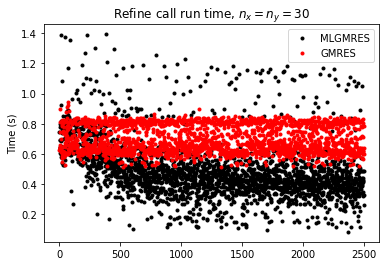

In [8]:
pp.plot(run_timeP2_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r',label='GMRES')
pp.title('Refine call run time, $n_x=n_y=30$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime1.svg')

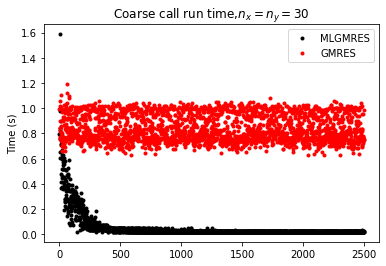

In [9]:
pp.plot(run_timeP1_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r',label='GMRES')
pp.title('Coarse call run time,$n_x=n_y=30$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime2.svg')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


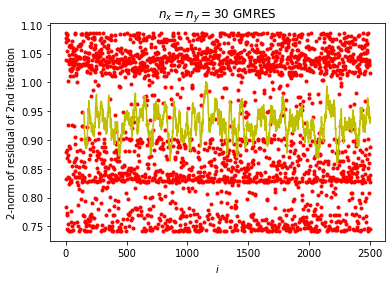

In [10]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[150:-1],AVG[150:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=30$ GMRES')
pp.savefig('GMRES.svg')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


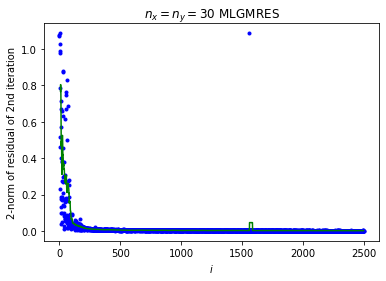

In [11]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=30$ MLGMRES')
pp.savefig('MLGMRES.svg')

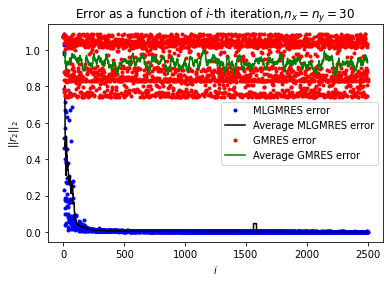

In [12]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('$||r_2||_2$')
pp.title('Error as a function of $i$-th iteration,$n_x=n_y=30$ ')
pp.legend(loc='best')
pp.savefig('Compare.svg')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


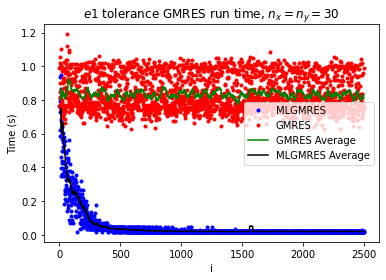

In [13]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n_x=n_y=30$')
pp.legend(loc='best')
pp.savefig('Runtime1.svg')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


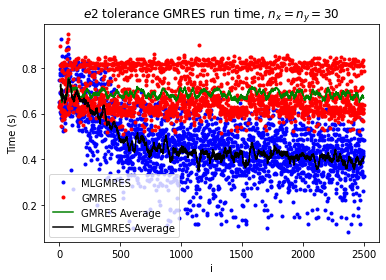

In [14]:
GmresRunTimeOriginal2_AVG=np.zeros((n_steps,1))
ML_GMRES_Time2_AVG=np.zeros((n_steps,1))
count=np.arange(0,n_steps)


for j in range(0,n_steps):
    GmresRunTimeOriginal2_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal2[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time2_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list2[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list2,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal2_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time2_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e2$ tolerance GMRES run time, $n_x=n_y=30$')
pp.legend(loc='best')
pp.savefig('Runtime2.svg')

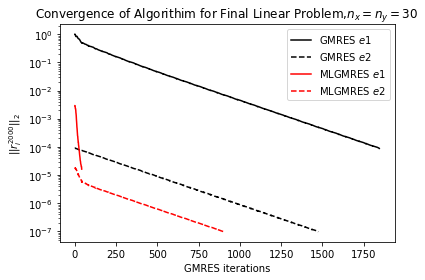

In [15]:
ML_Err=resid(A, Out, b/b_norm)
ML_Err2=resid(A, Out2, b/b_norm)



NonML_Err=resid(A, NonML_Out1, b/b_norm)
NonML_Err2=resid(A, NonML_Out2, b/b_norm)

pp.semilogy(NonML_Err,'k',label='GMRES $e1$')
pp.semilogy(NonML_Err2,'--k',label='GMRES $e2$')
pp.semilogy(ML_Err,'r',label='MLGMRES $e1$')
pp.semilogy(ML_Err2,'--r',label='MLGMRES $e2$')
pp.legend(loc='best')
pp.xlabel('GMRES iterations')
pp.ylabel('$||r^{2000}_{i}||_2$')
pp.title('Convergence of Algorithim for Final Linear Problem,$n_x=n_y=30$')
pp.savefig('Error.svg')

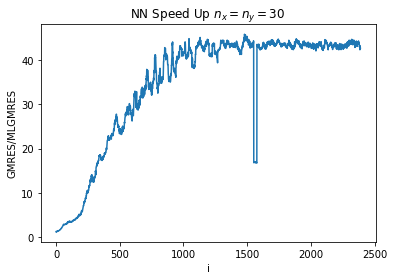

In [16]:
GMRESAVG=GmresRunTimeOriginal_AVG[10:-100]
MLGMRESAVG=ML_GMRES_Time_AVG[10:-100]
Ratio=np.divide(GMRESAVG,MLGMRESAVG)



pp.plot(Ratio)
pp.xlabel('i')
pp.ylabel('GMRES/MLGMRES')
pp.title("NN Speed Up $n_x=n_y=30$ ")
pp.savefig('SpeedUp.svg')

Text(0.5, 1.0, 'Error Ratio $n_x=n_y=30$ ')

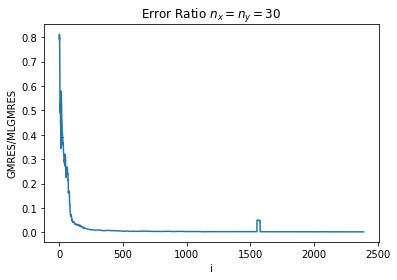

In [17]:
MLError_AVG=AVGML[10:-100]
Error_AVG=AVG[10:-100]
Ratio=np.divide(MLError_AVG,Error_AVG)



pp.plot(Ratio)
pp.xlabel('i')
pp.ylabel('GMRES/MLGMRES')
pp.title("Error Ratio $n_x=n_y=30$ ")

In [18]:
Err_Array=np.expand_dims(np.asarray(NonML_Err_List),axis=1)
Err_Array_ML=np.expand_dims(np.asarray(Err_list),axis=1)
GmresTime1Arr=np.expand_dims(np.asarray(GmresRunTimeOriginal),axis=1)
MLGmresTime1Arr=np.expand_dims(np.asarray(ML_GMRES_Time_list),axis=1)
GmresTime2Arr=np.expand_dims(np.asarray(GmresRunTimeOriginal2),axis=1)
MLGmresTime2Arr=np.expand_dims(np.asarray(ML_GMRES_Time_list2),axis=1)

WriteDataArr=np.concatenate((Err_Array_ML,Err_Array,GmresTime1Arr,MLGmresTime1Arr,GmresTime2Arr,MLGmresTime2Arr),axis=1)
np.savetxt('PerformanceData.txt',WriteDataArr)